# QAOA for Graph Coloring Problem
In this tutorial, we will solve the Graph Coloring Problem using the Quantum Approximate Optimization Algorithm (QAOA).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import networkx as nx
import qiskit.primitives as qk_pr

import jijmodeling as jm
import ommx.v1

import qamomile.core as qm
from qamomile.qiskit import QiskitTranspiler
from qamomile.core.circuit.drawer import plot_quantum_circuit

First, we will implement the mathematical model of the graph coloring problem using JijModeling.

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

Next, we will create an instance of the problem.

In [ ]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])

NameError: name 'nx' is not defined

In [4]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

# Quantum Approximate Optimazation Algorithm (QAOA)
The Quantum Approximate Optimization Algorithm (QAOA) is one of the quantum optimization algorithms that use a variational quantum circuit. For a detailed explanation, please refer to paper [1], but here we will only give a rough overview.
In QAOA, a variational quantum circuit is constructed by applying the Ising Hamiltonian $H_P = \sum_{ij}J_{ij}Z_iZ_j$ and the $X$-mixer Hamiltonian $H_M = \sum_iX_i$ in the following way:
If we start with an initial state $\ket{\psi_0}$, then

$$
\ket{\psi(\beta,\gamma)} = e^{-i\beta_pH_M}e^{-i\gamma_pH_P}\cdots e^{-i\beta_1H_M}e^{-i\gamma_1H_P}\ket{\psi_0}
$$

can be written. Here, $\beta_k,\gamma_k$ are the parameters to be optimized, and since the operation $e^{-\beta_kH_M}e^{-\gamma_kH_P}$ is repeated $p$ times, there are a total of $2p$ parameters. In the standard QAOA, the total number of parameters is independent of the number of qubits and depends only on the number of repetitions.

Optimization of $\beta_k,\gamma_k$ is performed by repeating the following steps 1 and 2:

1. Compute the expectation value $\bra{\psi(\beta,\gamma)}H_P\ket{\psi(\beta,\gamma)}$ on a quantum device.
2. Update the parameters on a classical computer to minimize the expectation value.

By repeating this calculation of the expectation value on the quantum computer and optimization of parameters on the classical computer, we obtain the minimum energy $\langle H_P \rangle$ and the corresponding final state. If we consider QAOA as a mathematical optimization algorithm, this minimum energy corresponds to the minimum objective function value, and the final state becomes the optimal solution.

## Implementing QAOA using Qamomile
Now, let's try solving the Graph Coloring Problem using QAOA.
To execute QAOA, it's necessary to convert the mathematical model into an Ising Hamiltonian, and then create a variational quantum circuit and Hamiltonian using a quantum computing library. However, since Qamomile supports QAOA, it allows for relatively easy execution.

First, using JijModeling.Interpreter, we create a ommx.Instance from JijModeling's mathematical model and instance data.

In [16]:
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

Next, we create a QAOAConverter. By setting the weight for the constraints on this Converter, we can create the Hamiltonian.

In [ ]:
qaoa_converter = qm.qaoa.QAOAConverter(instance)
qaoa_converter.ising_encode(multipliers={"one-color": 5})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

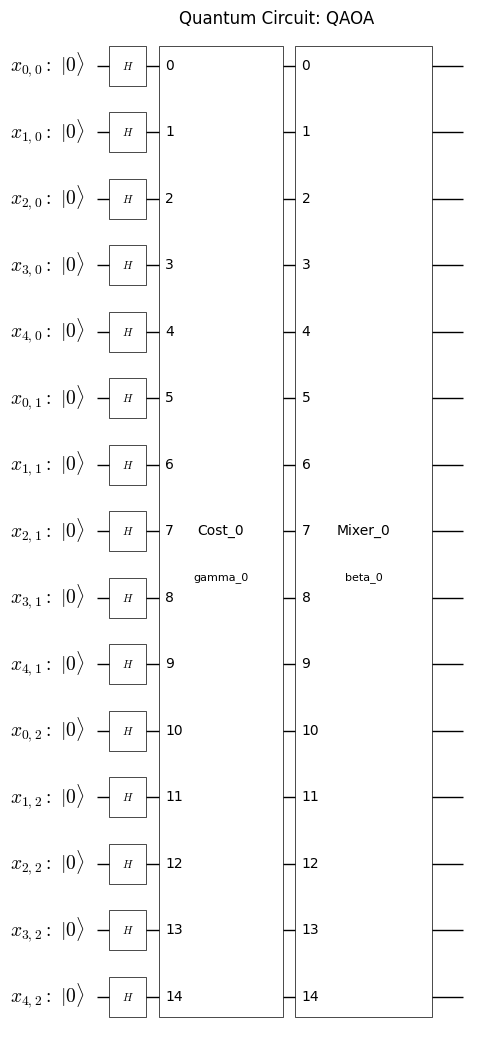

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

## Run QAOA using Qiskit

Now that we have the variational quantum circuit and Hamiltonian ready, let's actually execute QAOA using Qiskit.  
Transpile the qamomile's circuit to the qiskit's circuit and run the simulation.

In [8]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

In [9]:
# Variational Step
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 1000})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.8539634674558334
       x: [ 4.544e-01 -3.551e-01]
    nfev: 409
   maxcv: 0.0

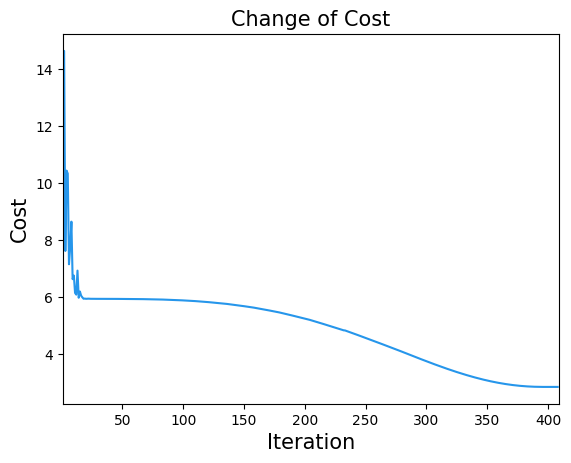

In [10]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [11]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()

In [12]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

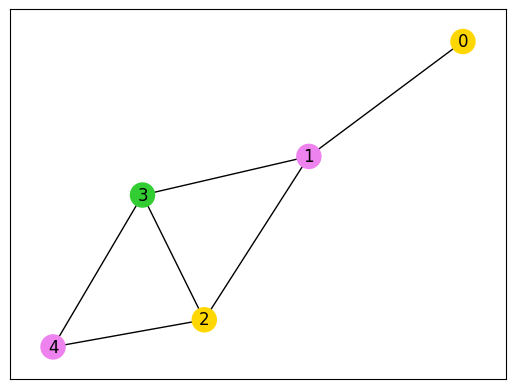

In [13]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.experimental.SampleSet):
    # extract feasible solution
    feasibles = sampleset.feasibles()
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.lowest()[0]

        # get indices of x = 1
        indices = lowest_sample.var_values["x"].values.keys()
        # get vertices and colors
        # initialize vertex color list
        node_colors = [-1] * graph.number_of_nodes()
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

# Visualize the graph coloring result
plot_graph_coloring(G, sampleset)